# Libraries

In [94]:
from sklearn import datasets
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Functions for Learning Rate, Sigmoid Activation, and Loss Calculation


In [95]:
#Defining the LearningSchedule
def LearningSchedule(t, initial_eta=0.1, decay=0.01):
    return initial_eta / (1 + decay * t)

# Defining the sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#Defining the loss function
def binary_cross_entropy_loss(y_true, y_pred):
    return log_loss(y_true, y_pred, labels=[0, 1])


# Loading and Preparing the Breast Cancer Dataset


In [96]:
#Dataset
data = datasets.load_breast_cancer()
X, y = data.data, data.target
print("Original unique values in y:", np.unique(y))

# Converting y to binary if necessary
threshold = 0.5
y_binary = (y > threshold).astype(int)
print("Unique values in binary y:", np.unique(y_binary))

Original unique values in y: [0 1]
Unique values in binary y: [0 1]


# Implementing Logistic regression

In [97]:
def LogisticRegression(X_train, y_train, X_test, y_test, Beta, M, epochs, initial_eta, rho, lmbda=None):
    Loss_epochs_train = []
    Loss_epochs_test = []
    accuracy_epochs_train = []
    accuracy_epochs_test = []
    Eta = []
    velocity = np.zeros_like(Beta)
    old_velocity = 0
    
    for epoch in range(1, epochs + 1):
        indices = np.random.permutation(len(y_train))
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        Loss_batch_temp = []
        
        for i in range(0, len(y_train), M):
            # Mini-batch selection
            Xi = X_shuffled[i:i + M]
            yi = y_shuffled[i:i + M]
            
            if len(yi) < M:
                continue
                
            # Prediction and gradient computation
            ypred = sigmoid(Xi @ Beta)
            gradient = (1 / len(Xi)) * Xi.T @ (ypred - yi)
            
            # Adaptive learning rate
            eta = LearningSchedule(epoch * M + i, initial_eta)
            Eta.append(eta)
            
            # Regularization term
            if lmbda is not None:
                gradient += 2 * lmbda * Beta
            
            # Update Beta with momentum or plain gradient descent
            if rho > 0:
                velocity = rho * old_velocity + eta * gradient
                Beta -= velocity
                old_velocity = velocity
            else:
                Beta -= eta * gradient
        
        # Calculating epoch loss for training set
        ypred_epoch_train = sigmoid(X_train @ Beta) 
        Loss_epochs_train.append(binary_cross_entropy_loss(y_train, ypred_epoch_train))  # Using binary_cross_entropy_loss
        
        # Calculating epoch accuracy for training set
        ypred_epoch_train = np.round(ypred_epoch_train)
        epoch_accuracy_train = accuracy_score(y_train, ypred_epoch_train)
        accuracy_epochs_train.append(epoch_accuracy_train)
        
        # Calculating epoch loss and accuracy for test set
        ypred_epoch_test = sigmoid(X_test @ Beta) 
        Loss_epochs_test.append(binary_cross_entropy_loss(y_test, ypred_epoch_test))  # Using binary_cross_entropy_loss
        
        #Calculating epoch accuracy for test set
        ypred_epoch_labels_test = np.round(ypred_epoch_test)
        epoch_accuracy_test = accuracy_score(y_test, ypred_epoch_labels_test)
        accuracy_epochs_test.append(epoch_accuracy_test)
        
    return Beta, Loss_epochs_train, Loss_epochs_test, accuracy_epochs_train, accuracy_epochs_test, Eta



# Splitting and Scaling the Dataset for Training and Testing


In [98]:
# Sample data
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initializing Parameters and Running the Logistic Regression Model


In [101]:
# Initializing Beta
Beta = np.random.randn(X_train_scaled.shape[1]) * 0.01  # or use zeros for initialization

# Setting hyperparameters
M = 10  # Mini-batch size
epochs = 200
initial_eta =0.01
rho = 0.2
lmbda = 0.1  # Regularization parameter (adjust as needed)

# Running the function
Beta, MSE_train, MSE_test, accuracy_train, accuracy_test, Eta = LogisticRegression(
    X_train_scaled, y_train, X_test_scaled, y_test, Beta, M, epochs, initial_eta, rho, lmbda
)

# Print results
print("Final training loss:", MSE_train[-1])
print("Final test loss:", MSE_test[-1])
print("Final training accuracy:", accuracy_train[-1])
print("Final test accuracy:", accuracy_test[-1])



Final training loss: 0.18610422512273558
Final test loss: 0.1729129816648058
Final training accuracy: 0.967032967032967
Final test accuracy: 0.9736842105263158


# Visualizing Loss and Accuracy During Training and Testing


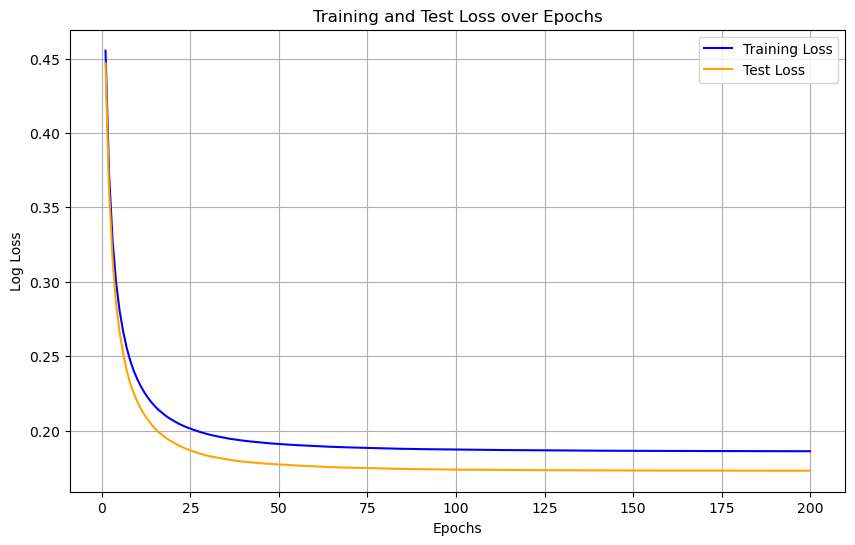

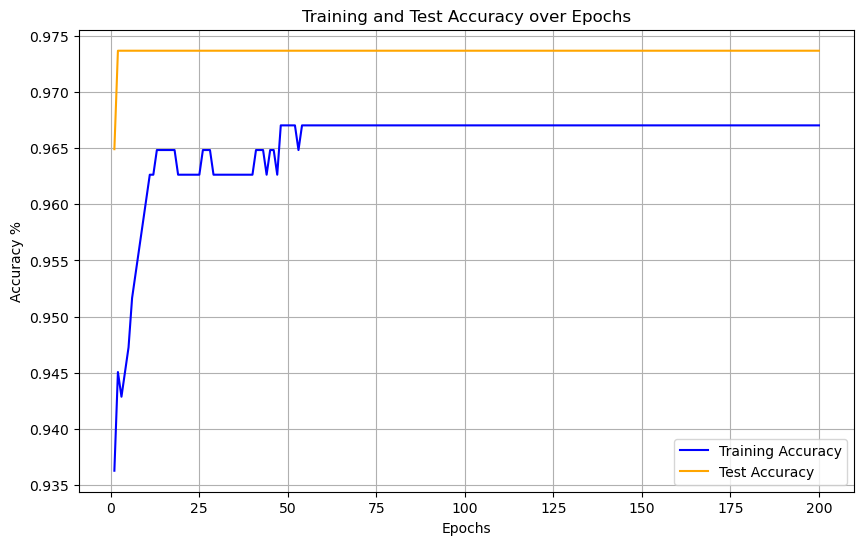

In [100]:
#Plotting loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), MSE_train, label='Training Loss', color='blue')
plt.plot(range(1, epochs + 1), MSE_test, label='Test Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("Training and Test Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plotting accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), accuracy_train, label='Training Accuracy', color='blue')
plt.plot(range(1, epochs + 1), accuracy_test, label='Test Accuracy', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Training and Test Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()

# Evaluating the Impact of Regularization and Learning Rate on Model Performance


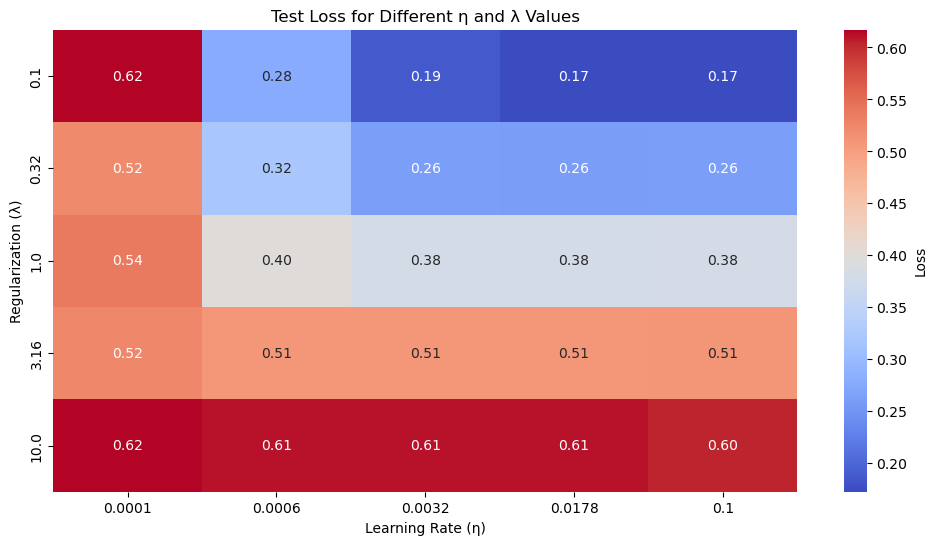

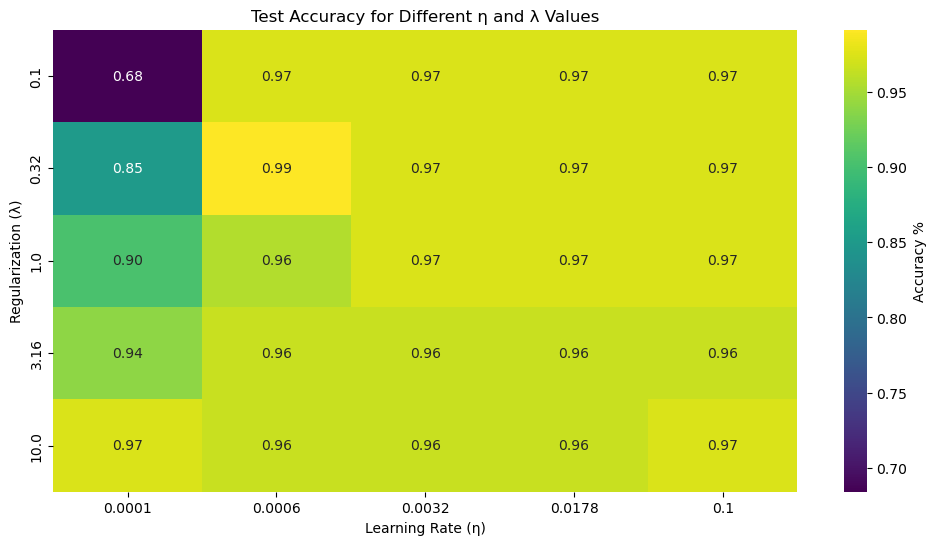

In [79]:
# Defining lambda and initial_eta values for testing
n_lambdas = 5
lmbda_values = np.round(np.logspace(-1,1, n_lambdas),2)  # Regularization values
initial_eta_values = np.round(np.logspace(-4, -1, n_lambdas), 4)   # Learning rate values

# Initializing grids to store the final loss and accuracy for each (lambda, initial_eta) pair
final_loss_grid = np.zeros((len(lmbda_values), len(initial_eta_values)))
final_accuracy_grid = np.zeros((len(lmbda_values), len(initial_eta_values)))

# Looping through each combination of lambda and initial_eta
for i, lmbda in enumerate(lmbda_values):
    for j, initial_eta in enumerate(initial_eta_values):
        # Initializing Beta and train the model
        Beta = np.random.randn(X_train.shape[1]) * 0.1  # Initial Beta
        
        # Running logistic regression with the current lambda and initial_eta
        Beta, Loss_epochs_train, Loss_epochs_test, accuracy_epochs_train, accuracy_epochs_test, Eta = LogisticRegression(
           X_train_scaled, y_train, X_test_scaled, y_test, Beta, M=10, epochs=50, initial_eta=initial_eta, rho=0.6, lmbda=lmbda
        )
        
        # Storing the final loss and accuracy for this (lambda, initial_eta) combination
        final_loss_grid[i, j] = Loss_epochs_test[-1]         # Last epoch test loss
        final_accuracy_grid[i, j] = accuracy_epochs_test[-1]  # Last epoch test accuracy


# Converting the grids to DataFrames for plotting
loss_df = pd.DataFrame(final_loss_grid, index=lmbda_values, columns=initial_eta_values)
accuracy_df_Logistic = pd.DataFrame(final_accuracy_grid, index=lmbda_values, columns=initial_eta_values)

# Plotting the heatmap for final test loss
plt.figure(figsize=(12, 6))
sns.heatmap(loss_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, cbar_kws={'label': "Loss"})
plt.xlabel("Learning Rate (η)")
plt.ylabel("Regularization (λ)")
plt.title("Test Loss for Different η and λ Values")
plt.show()
    

# Logistic regression using Scikit-learn

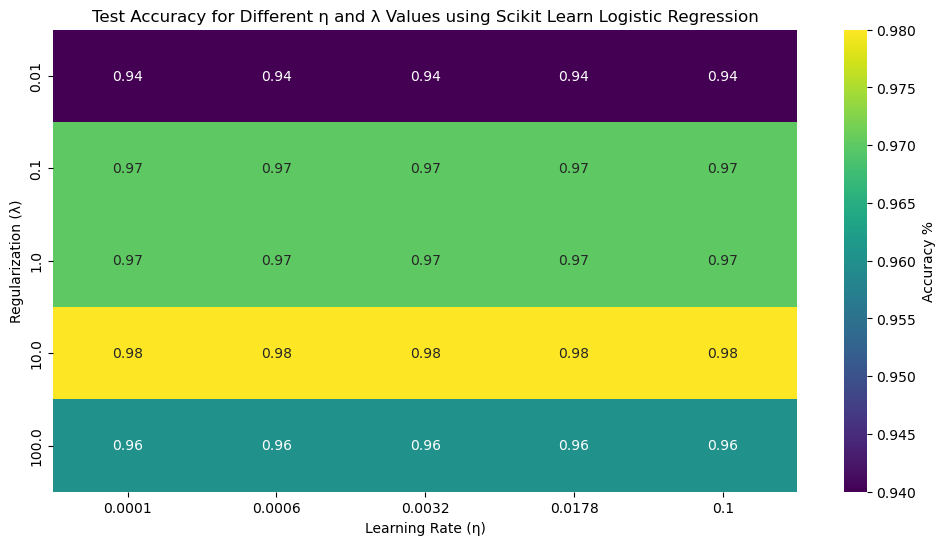

In [83]:
# Define extended ranges for lambda (regularization) and eta (learning rate) values
lambda_values = np.logspace(-2, 2, 5)  # Regularization values
eta_values = np.logspace(-4, -1, 5)  # Learning rate values

# Initialize grid to store test accuracy for each (lambda, eta) pair
test_accuracy_grid = np.zeros((len(lambda_values), len(eta_values)))

# Loop through each combination of lambda and eta
for i, lambda_val in enumerate(lambda_values):
    for j, eta in enumerate(eta_values):
        # Regularization strength C (inverse of lambda)
        C = 1 / lambda_val

        # Initialize and train the logistic regression model
        model = LogisticRegression(C = C, solver='lbfgs', max_iter=1000, random_state=42)
        model.fit(X_train_scaled, y_train)

        # Predict and compute test accuracy
        y_pred = model.predict(X_test_scaled)
        test_accuracy_grid[i, j] = accuracy_score(y_test, y_pred)

# Convert results to a DataFrame and round for display
accuracy_df_scikit = pd.DataFrame(test_accuracy_grid, index=lambda_values, columns=eta_values)
accuracy_df_scikit= accuracy_df_scikit.round(2)

# Round index and column labels for clear display
accuracy_df_scikit.index = [round(val, 5) for val in accuracy_df.index]
accuracy_df_scikit.columns = [round(val, 4) for val in accuracy_df.columns]



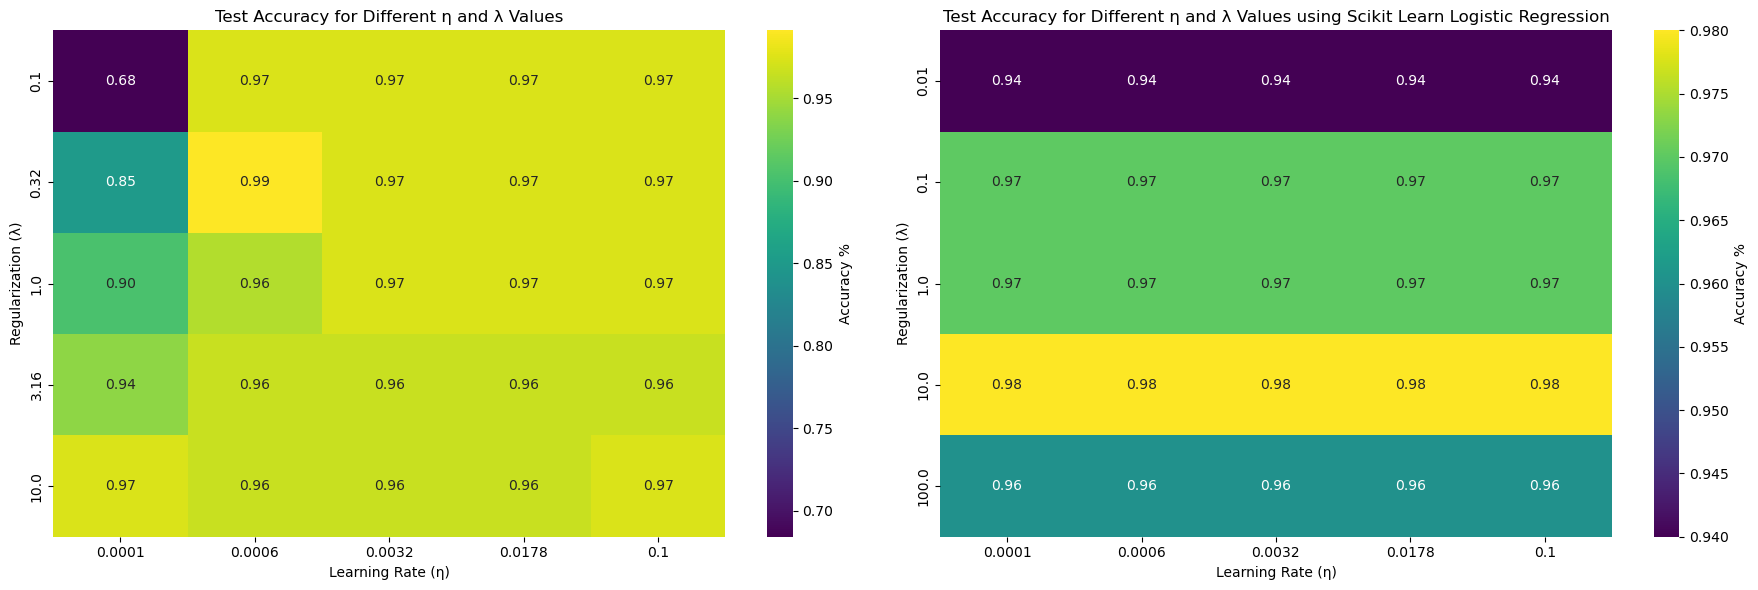

In [84]:
# Plotting the heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# First plot
sns.heatmap(accuracy_df_Logistic, annot=True, fmt=".2f", cmap="viridis", cbar=True, ax=axes[0], cbar_kws={'label': "Accuracy %"})
axes[0].set_xlabel("Learning Rate (η)")
axes[0].set_ylabel("Regularization (λ)")
axes[0].set_title("Test Accuracy for Different η and λ Values")

# Second plot
sns.heatmap(accuracy_df_scikit, annot=True, fmt=".2f", cmap="viridis", cbar=True, ax=axes[1], cbar_kws={'label': "Accuracy %"})
axes[1].set_xlabel("Learning Rate (η)")
axes[1].set_ylabel("Regularization (λ)")
axes[1].set_title("Test Accuracy for Different η and λ Values using Scikit Learn Logistic Regression")

plt.tight_layout()
plt.show()